# Credit Risk Analysis: Loan Default Prediction
## NB08 — Business Summary & Deployment Recommendations

---

### Executive Summary

This project developed a machine learning model to predict loan defaults on a portfolio of 270,887 Lending Club consumer loans, covering the full analytics workflow from raw data through model deployment recommendations. An XGBoost classifier trained on 53 features — including raw loan characteristics, borrower financial stress ratios, and purpose-built risk indicators engineered from domain knowledge — achieves **82.4% recall** at a decision threshold tuned for a 5:1 cost asymmetry between missed defaults and false declines. On a representative portfolio of 10,000 loans at the dataset's 22.6% default rate, the model prevents an estimated **$15.2M in default losses** while incurring $7.9M in foregone interest from incorrectly declined creditworthy borrowers, delivering a **net financial benefit of approximately $7.3M** — compared to $18.5M in unmitigated losses without any screening. Model decisions are fully explainable through SHAP value analysis, with Lending Club's internal risk grade, compound debt stress ratios, and loan term confirmed as the primary default risk drivers. An independent Weight of Evidence (WoE) scorecard analysis provides a transparent, regulatory-friendly alternative that achieves 98% of the ML model's discriminatory power, demonstrating awareness of both the modern machine learning and traditional credit scoring approaches used across the industry.


---
## 1. The Business Problem

### Why predicting loan defaults matters

Every lending decision carries two types of risk:

**The risk of approving a borrower who defaults.** When a borrower fails to repay, the lender loses the outstanding principal minus whatever they recover through collections — typically 60% of the loan balance is unrecoverable (this 60% figure is called **Loss Given Default, or LGD**). On a $13,628 average loan (this dataset's mean), a default costs approximately **$8,177 in expected losses**.

**The risk of declining a borrower who would have repaid.** A false decline doesn't cause an immediate loss — it causes a missed revenue opportunity. The lender forgoes the interest income the loan would have generated. At a 13.89% average rate on a $13,628 loan, that's roughly **$1,893 in first-year foregone interest**.

These two error types are not symmetric. A missed default costs roughly **4.3× more** than a false decline in dollar terms — which is why we set a 5:1 cost ratio (slightly conservative, giving regulators and the business a buffer) as the optimization target throughout this project.

### The class imbalance challenge

22.6% of loans in this dataset defaulted. That sounds like a lot — but it means 77.4% of borrowers repaid fully. A model that simply approves everyone would be "77.4% accurate" while being **completely useless** for its intended purpose. This is the class imbalance problem: training a model on skewed data causes it to optimize for the majority class (full repayment) at the expense of the minority class (default) — which is precisely the class we need to catch.

Addressing class imbalance was a central design decision: we tested both SMOTE (Synthetic Minority Oversampling Technique, which creates artificial default examples to balance the training data) and class weighting (which tells the model that misclassifying a default is more costly than misclassifying a repayment). Class weighting won on all metrics and was carried through to the final model.

### What good looks like

The goal is not to minimize overall error rate. The goal is to catch as many true defaults as possible while keeping false alarms at a level the business can operationally absorb. In lending, this trade-off is managed through **threshold tuning**: instead of flagging any loan where the model assigns >50% default probability (the default threshold), we lower the bar to 40%, catching more defaults at the cost of more false alarms. Every percentage point of recall recovered pays for itself if the cost asymmetry justifies it — and at 4.3–5:1, it does.


DATASET OVERVIEW
  Total loans:             270,887
  Fully paid:              209,711  (77.4%)
  Defaulted:                61,176  (22.6%)
  Train set size:          216,709  (80%)
  Test set size:            54,178  (20%, held-out)
  Feature count:                53  features
  Avg loan amount:      $   13,628
  Median loan amount:   $   12,000
  Avg interest rate:        13.89%
  Avg DTI:                  16.70%


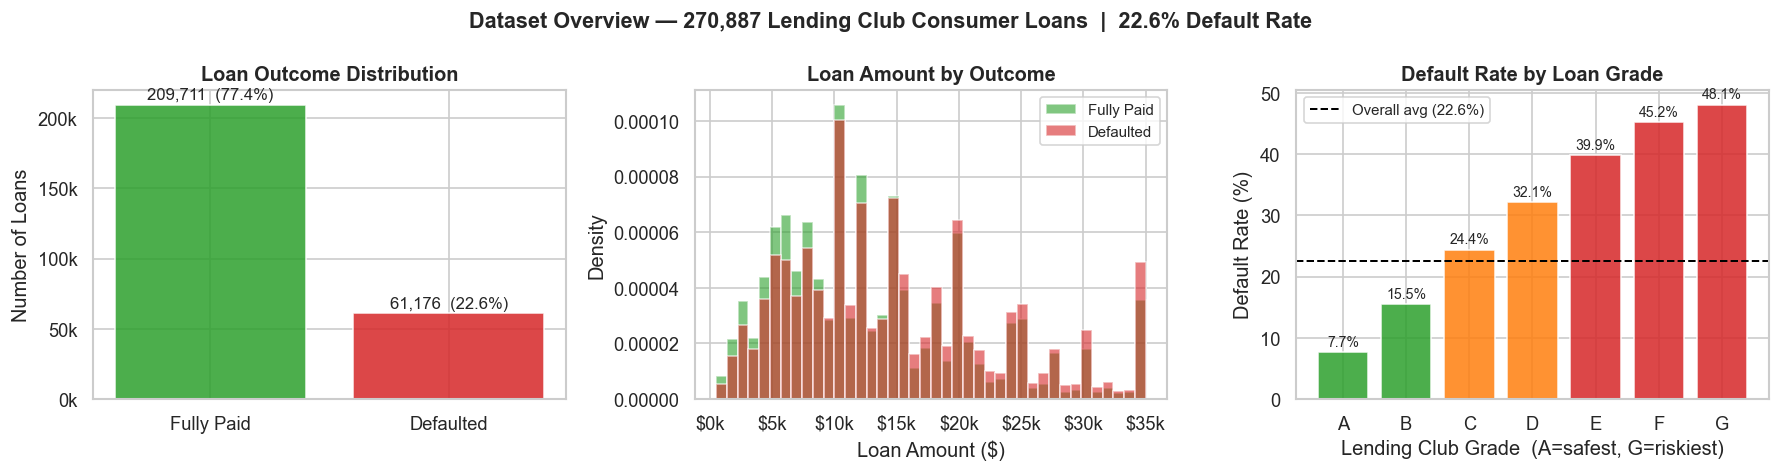

Saved: outputs/nb08_dataset_overview.png


In [1]:
# ── Portable root detection ───────────────────────────────────────────────────
from pathlib import Path
import os

root = Path.cwd()
while not (root / '.git').exists() and root != root.parent:
    root = root.parent
os.chdir(root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import seaborn as sns
import json, joblib, warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# ── Load data ─────────────────────────────────────────────────────────────────
# Using the engineered dataset for dataset-level stats (full 270k rows)
# and the train/test splits for model evaluation
clean_df = pd.read_parquet('data/engineered/lending_club_engineered.parquet')
test_df  = pd.read_parquet('data/splits/test.parquet')

with open('outputs/model_metadata.json') as f:
    meta = json.load(f)

# ── Key dataset statistics ────────────────────────────────────────────────────
n_total    = len(clean_df)
n_defaults = clean_df['target'].sum()
n_paid     = n_total - n_defaults
default_rt = n_defaults / n_total
avg_loan   = clean_df['loan_amnt'].mean()
med_loan   = clean_df['loan_amnt'].median()
avg_rate   = clean_df['int_rate'].mean()
avg_dti    = clean_df['dti'].mean()

print("DATASET OVERVIEW")
print("=" * 55)
print(f"  Total loans:          {n_total:>10,}")
print(f"  Fully paid:           {n_paid:>10,}  ({n_paid/n_total*100:.1f}%)")
print(f"  Defaulted:            {n_defaults:>10,}  ({default_rt*100:.1f}%)")
print(f"  Train set size:       {meta['train_rows']:>10,}  (80%)")
print(f"  Test set size:        {meta['test_rows']:>10,}  (20%, held-out)")
print(f"  Feature count:        {meta['n_features']:>10,}  features")
print("=" * 55)
print(f"  Avg loan amount:      ${avg_loan:>9,.0f}")
print(f"  Median loan amount:   ${med_loan:>9,.0f}")
print(f"  Avg interest rate:    {avg_rate:>9.2f}%")
print(f"  Avg DTI:              {avg_dti:>9.2f}%")
print("=" * 55)

# ── Dataset overview chart ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Target distribution
ax = axes[0]
counts = [n_paid, n_defaults]
colors = ['#2ca02c', '#d62728']
bars = ax.bar(['Fully Paid', 'Defaulted'], counts, color=colors, alpha=0.85, edgecolor='white')
for bar, cnt, pct in zip(bars, counts, [n_paid/n_total, default_rt]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1500,
            f'{cnt:,}  ({pct*100:.1f}%)', ha='center', va='bottom', fontsize=10)
ax.set_title('Loan Outcome Distribution', fontweight='bold')
ax.set_ylabel('Number of Loans')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}k'))

# Loan amount distribution by outcome
ax = axes[1]
for outcome, label, color in [(0, 'Fully Paid', '#2ca02c'), (1, 'Defaulted', '#d62728')]:
    ax.hist(clean_df.loc[clean_df['target']==outcome, 'loan_amnt'],
            bins=40, alpha=0.6, label=label, color=color, density=True)
ax.set_title('Loan Amount by Outcome', fontweight='bold')
ax.set_xlabel('Loan Amount ($)')
ax.set_ylabel('Density')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.legend(fontsize=9)

# Default rate by loan grade
ax = axes[2]
grade_map = {i: g for i, g in enumerate(['A','B','C','D','E','F','G'], 1)}
clean_df['grade_letter'] = clean_df['sub_grade_numeric'].apply(
    lambda x: grade_map.get(int(np.ceil(x/5)), 'G'))
grade_dr = clean_df.groupby('grade_letter')['target'].mean() * 100
grade_dr = grade_dr.reindex(['A','B','C','D','E','F','G'])
colors_g = ['#2ca02c' if v < 20 else '#ff7f0e' if v < 35 else '#d62728'
            for v in grade_dr.values]
ax.bar(grade_dr.index, grade_dr.values, color=colors_g, alpha=0.85, edgecolor='white')
ax.axhline(default_rt*100, color='black', linestyle='--', linewidth=1.2,
           label=f'Overall avg ({default_rt*100:.1f}%)')
ax.set_title('Default Rate by Loan Grade', fontweight='bold')
ax.set_xlabel('Lending Club Grade  (A=safest, G=riskiest)')
ax.set_ylabel('Default Rate (%)')
ax.legend(fontsize=9)
for x, (grade, rate) in enumerate(grade_dr.items()):
    ax.text(x, rate + 0.5, f'{rate:.1f}%', ha='center', va='bottom', fontsize=8.5)

plt.suptitle('Dataset Overview — 270,887 Lending Club Consumer Loans  |  22.6% Default Rate',
             fontsize=13, fontweight='bold')
plt.tight_layout()
os.makedirs('outputs', exist_ok=True)
plt.savefig('outputs/nb08_dataset_overview.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/nb08_dataset_overview.png")


---
## 2. Analytical Approach

This project followed an eight-stage workflow, with explicit **breakpoints** at each stage where business decisions were required before analysis could continue. The principle throughout was that modeling choices are not purely technical — they encode business judgments about what outcomes matter most.

### Stage 1 — Data Exploration (NB01)
Profiled 887,379 raw Lending Club loan records to identify data quality issues: post-loan leakage columns (variables recorded *after* the loan was issued that would not be available at application time and would artificially inflate model performance), missing value patterns, outliers, and the 22.6% baseline default rate on the resolved-loan subset.

### Stage 2 — Data Cleaning (NB02)
Resolved all quality issues: dropped leakage and administrative columns, applied binary flag + sentinel-fill imputation for informatively missing delinquency timing columns, capped annual income at the 99th percentile ($240k), and corrected impossible revolving utilization values (>100%). Produced a clean dataset of 270,887 loans.

### Stage 3 — Feature Engineering (NB03)
Constructed 20 domain-specific features organized into five groups: debt stress indicators (e.g., `loan_to_income_ratio`), revolving utilization flags (e.g., `high_util_flag`), delinquency severity scores, behavioral flags, and interaction terms. The most important interaction — `dti_x_loan_to_income` (debt-to-income ratio multiplied by loan-to-income ratio) — later emerged as the #2 ranked feature by both SHAP and Information Value.

### Stage 4 — Baseline Modeling (NB04)
Established a naive logistic regression baseline (11.7% recall — essentially useless for default detection), then tested three class imbalance strategies: no adjustment, class weighting, and SMOTE oversampling. This stage also established the **5:1 cost ratio** (a missed default costs 5× a false decline) that governed all subsequent threshold optimization decisions.

### Stage 5 — Tree-Based Modeling (NB05)
Tuned Random Forest and XGBoost models with RandomizedSearchCV (50 iterations, 5-fold stratified cross-validation, PR-AUC scoring). Class weighting consistently outperformed SMOTE for both architectures. **XGBoost with class weighting** was selected as the final model based on superior cost-weighted performance. The decision threshold was revised from 0.30 to **0.40**, accepting a modest recall reduction (82.4% vs. 83.5%) in exchange for 143 fewer false alarms per 10,000 loans — a business trade-off favoring customer experience over raw default capture rate.

### Stage 6 — Model Interpretability (NB06)
Applied SHAP (SHapley Additive exPlanations) to explain the model's predictions at both global and individual levels. Confirmed that the top risk drivers are Lending Club's internal risk grade, compound debt stress ratios, and 60-month loan term flag. Demonstrated that the engineered interaction features contribute meaningfully beyond the raw input features.

### Stage 7 — WoE/IV Exploration (NB07)
Applied Weight of Evidence (WoE) binning and Information Value (IV) analysis — the traditional credit scoring methodology — as an independent validation of feature importance and as a scorecard prototype. The WoE scorecard using only 10 features achieved **ROC-AUC = 0.7045**, representing 98.2% of XGBoost's 0.7175 — demonstrating that the interpretability–performance trade-off is less severe than commonly assumed when high-quality features are selected.

### Key modeling decisions (traceability)

| Decision | Choice made | Business rationale |
|----------|-------------|-------------------|
| Imbalance strategy | Class weighting | Outperformed SMOTE; simpler to maintain |
| Model architecture | XGBoost | Higher PR-AUC and better cost-weighted score vs. Random Forest |
| Decision threshold | 0.40 | Reduces false alarms by 143/10k vs. 0.30 with only 11 fewer catches |
| Cost ratio | 5:1 | Slightly conservative estimate of missed-default-to-false-decline cost |
| SHAP sample | 15,000 stratified rows | Sufficient for stable estimates; computationally efficient |


FINAL MODEL PERFORMANCE — XGBoost + Class Weight @ threshold=0.40
Evaluated on held-out test set (54,178 loans, never seen during training)
  ROC-AUC:           0.7175
  PR-AUC:            0.4176
  Precision:         0.3088
  Recall:            0.8235
  F1:                0.4492
  True Positives:     10,076  (correctly flagged defaults)
  False Positives:    22,551  (false alarms — good borrowers declined)
  False Negatives:     2,159  (missed defaults — bad borrowers approved)
  True Negatives:     19,392  (correctly approved)
  Per 10,000 loans:
    Prevented losses:  $  15,207,176  (1860 defaults caught × $13,628 × 60% LGD)
    Missed losses:     $   3,258,465  (399 defaults missed)
    Foregone interest: $   7,879,111  (4162 false alarms × $13,628 × 13.89%)
    Net benefit:       $   7,328,065  vs. approving everyone
    No-model baseline: $  18,465,641  (all defaults undetected)


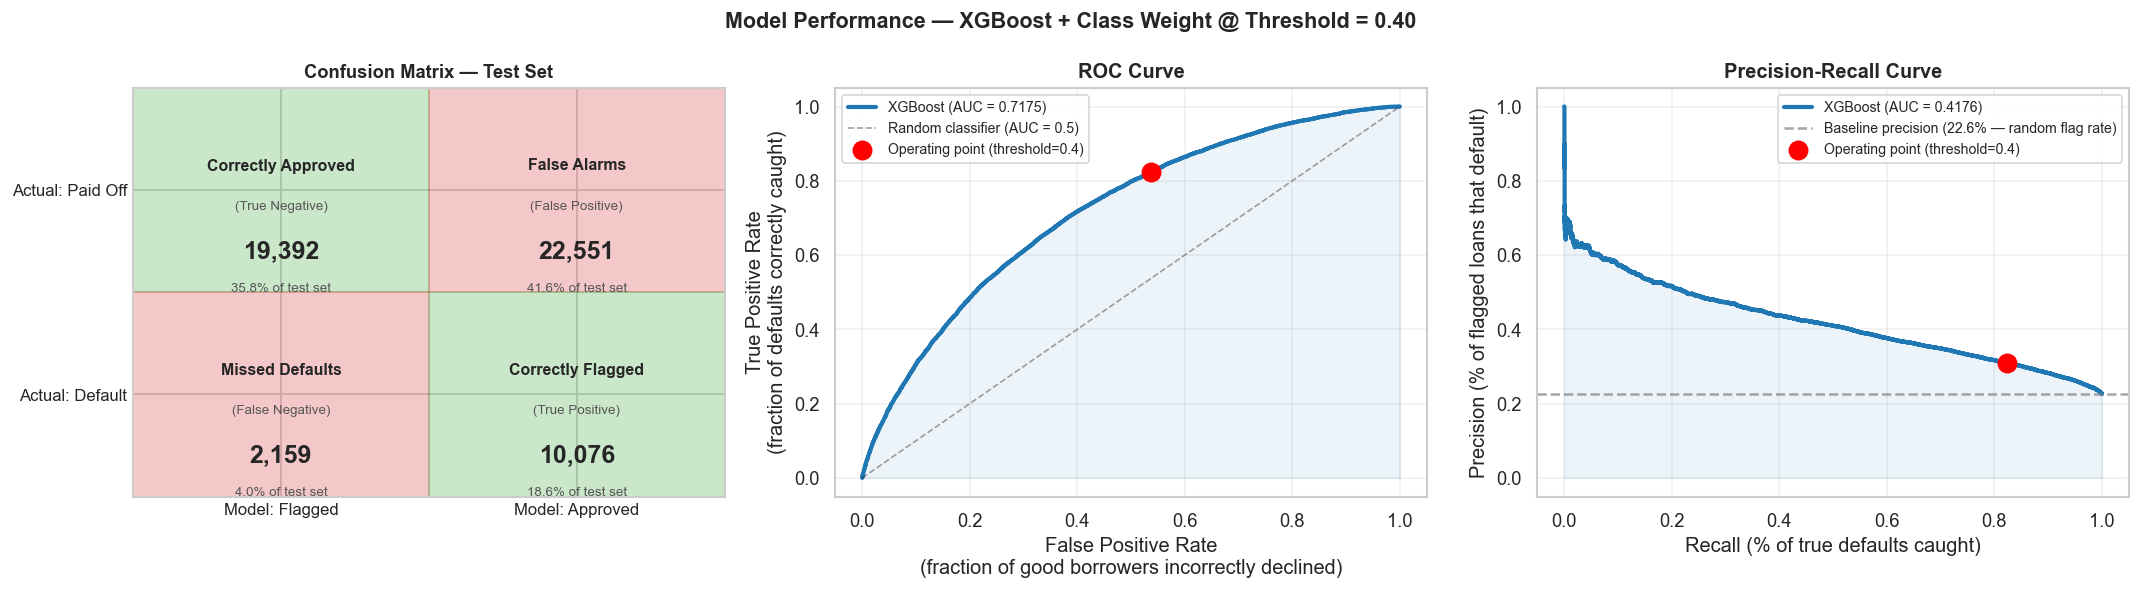

Saved: outputs/nb08_model_performance.png


In [2]:
# ── Load model and evaluate on test set ──────────────────────────────────────
from sklearn.metrics import (roc_auc_score, average_precision_score,
                              roc_curve, precision_recall_curve, confusion_matrix)

model     = joblib.load('outputs/best_model.joblib')
THRESHOLD = meta['threshold']

X_test = test_df.drop(columns='target')
y_test = test_df['target']

probs = model.predict_proba(X_test)[:, 1]
preds = (probs >= THRESHOLD).astype(int)

tp = meta['performance']['tp']
fp = meta['performance']['fp']
fn = meta['performance']['fn']
tn = meta['performance']['tn']
n_test      = tp + fp + fn + tn
scale_10k   = 10_000 / n_test
lgd         = 0.60

# Dollar impacts per 10,000 loans
avg_loan_amt = 13_628
avg_int_rate = 0.1389

prevented_loss  = tp * scale_10k * avg_loan_amt * lgd
missed_loss     = fn * scale_10k * avg_loan_amt * lgd
forgone_int     = fp * scale_10k * avg_loan_amt * avg_int_rate
no_model_loss   = (tp + fn) * scale_10k * avg_loan_amt * lgd
net_benefit     = prevented_loss - forgone_int

# ── Performance summary ───────────────────────────────────────────────────────
print("FINAL MODEL PERFORMANCE — XGBoost + Class Weight @ threshold=0.40")
print("Evaluated on held-out test set (54,178 loans, never seen during training)")
print("=" * 60)
print(f"  ROC-AUC:           {meta['performance']['roc_auc']:.4f}")
print(f"  PR-AUC:            {meta['performance']['pr_auc']:.4f}")
print(f"  Precision:         {meta['performance']['precision']:.4f}")
print(f"  Recall:            {meta['performance']['recall']:.4f}")
print(f"  F1:                {meta['performance']['f1']:.4f}")
print("=" * 60)
print(f"  True Positives:    {tp:>7,}  (correctly flagged defaults)")
print(f"  False Positives:   {fp:>7,}  (false alarms — good borrowers declined)")
print(f"  False Negatives:   {fn:>7,}  (missed defaults — bad borrowers approved)")
print(f"  True Negatives:    {tn:>7,}  (correctly approved)")
print("=" * 60)
print(f"  Per 10,000 loans:")
print(f"    Prevented losses:  ${prevented_loss:>12,.0f}  ({tp*scale_10k:.0f} defaults caught × ${avg_loan_amt:,} × {lgd:.0%} LGD)")
print(f"    Missed losses:     ${missed_loss:>12,.0f}  ({fn*scale_10k:.0f} defaults missed)")
print(f"    Foregone interest: ${forgone_int:>12,.0f}  ({fp*scale_10k:.0f} false alarms × ${avg_loan_amt:,} × {avg_int_rate:.2%})")
print(f"    Net benefit:       ${net_benefit:>12,.0f}  vs. approving everyone")
print(f"    No-model baseline: ${no_model_loss:>12,.0f}  (all defaults undetected)")

# ── Confusion matrix with business labels ─────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix
ax = axes[0]
cm_display = [[tn, fp], [fn, tp]]
# Colours: TN and TP are good outcomes (correctly classified)
cm_colors  = [['#2ca02c', '#d62728'], ['#d62728', '#2ca02c']]
cm_labels  = [['Correctly Approved', 'False Alarms'],
              ['Missed Defaults',    'Correctly Flagged']]
cm_sublabels = [['(True Negative)', '(False Positive)'],
                ['(False Negative)', '(True Positive)']]

for i in range(2):
    for j in range(2):
        ax.add_patch(plt.Rectangle((j, 1-i), 1, 1,
                                    color=cm_colors[i][j], alpha=0.25))
        ax.text(j+0.5, 1-i+0.62, cm_labels[i][j],
                ha='center', va='center', fontsize=9.5, fontweight='bold')
        ax.text(j+0.5, 1-i+0.42, cm_sublabels[i][j],
                ha='center', va='center', fontsize=8, color='#555555')
        ax.text(j+0.5, 1-i+0.20, f'{cm_display[i][j]:,}',
                ha='center', va='center', fontsize=15, fontweight='bold')
        ax.text(j+0.5, 1-i+0.02, f'{cm_display[i][j]/n_test*100:.1f}% of test set',
                ha='center', va='center', fontsize=8, color='#555555')

ax.set_xlim(0, 2); ax.set_ylim(0, 2)
ax.set_xticks([0.5, 1.5]); ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(['Model: Flagged', 'Model: Approved'], fontsize=10)
ax.set_yticklabels(['Actual: Default', 'Actual: Paid Off'], fontsize=10)
ax.set_title('Confusion Matrix — Test Set', fontweight='bold', fontsize=11)
ax.tick_params(length=0)

# ROC Curve
ax = axes[1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
ax.plot(fpr, tpr, '#1f77b4', linewidth=2.5,
        label=f'XGBoost (AUC = {meta["performance"]["roc_auc"]:.4f})')
ax.fill_between(fpr, tpr, alpha=0.08, color='#1f77b4')
ax.plot([0,1],[0,1], 'k--', alpha=0.4, linewidth=1, label='Random classifier (AUC = 0.5)')
# Mark operating threshold
idx = np.argmin(np.abs(thresholds - THRESHOLD))
ax.scatter(fpr[idx], tpr[idx], s=120, color='red', zorder=5,
           label=f'Operating point (threshold={THRESHOLD})')
ax.set_xlabel('False Positive Rate\n(fraction of good borrowers incorrectly declined)')
ax.set_ylabel('True Positive Rate\n(fraction of defaults correctly caught)')
ax.set_title('ROC Curve', fontweight='bold')
ax.legend(fontsize=8.5); ax.grid(True, alpha=0.3)

# Precision-Recall Curve
ax = axes[2]
prec_arr, rec_arr, pr_thresholds = precision_recall_curve(y_test, probs)
ax.plot(rec_arr, prec_arr, '#1f77b4', linewidth=2.5,
        label=f'XGBoost (AUC = {meta["performance"]["pr_auc"]:.4f})')
ax.fill_between(rec_arr, prec_arr, alpha=0.08, color='#1f77b4')
ax.axhline(y_test.mean(), color='gray', linestyle='--', alpha=0.7,
           label=f'Baseline precision ({y_test.mean()*100:.1f}% — random flag rate)')
# Mark operating threshold
idx2 = np.argmin(np.abs(pr_thresholds - THRESHOLD))
ax.scatter(rec_arr[idx2], prec_arr[idx2], s=120, color='red', zorder=5,
           label=f'Operating point (threshold={THRESHOLD})')
ax.set_xlabel('Recall (% of true defaults caught)')
ax.set_ylabel('Precision (% of flagged loans that default)')
ax.set_title('Precision-Recall Curve', fontweight='bold')
ax.legend(fontsize=8.5); ax.grid(True, alpha=0.3)

plt.suptitle('Model Performance — XGBoost + Class Weight @ Threshold = 0.40',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/nb08_model_performance.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/nb08_model_performance.png")


### Reading the Performance Numbers

**What the confusion matrix means for a loan officer:**

Every loan in the test set ends up in one of four buckets. The model correctly handles **56.5% of cases** (29,468 / 54,178: correctly approved + correctly flagged). The errors break into two categories with very different costs:

- **22,551 false alarms (41.6% of test set):** These are creditworthy borrowers the model incorrectly declined. Each one represents foregone interest income. At $13,628 average loan × 13.89% rate, that's approximately $1,893 in first-year income per borrower. This is the model's primary weakness — roughly 1 in 2 loans it flags as risky is actually safe.

- **2,159 missed defaults (4.0% of test set):** These are defaulters the model approved. Each represents ~$8,177 in expected loss (60% LGD × $13,628). Despite being far fewer in number, they account for a large fraction of financial exposure because each is ~5× more costly than a false alarm.

**The 30.9% precision is not a failure.** In a domain where defaults are 22.6% of the population, the model raises precision from a random 22.6% to 30.9% — a 37% improvement. But precision is necessarily constrained here: with 82.4% recall, the model casts a wide net to catch 4 out of 5 defaults, which means false alarms come with the territory. Raising precision to, say, 50% would require lowering recall to roughly 50% — catching only half of defaults, which at a 5:1 cost ratio is the wrong trade-off.

**What ROC-AUC and PR-AUC tell you:**

- **ROC-AUC = 0.7175** means the model correctly ranks a randomly chosen defaulter above a randomly chosen non-defaulter 71.75% of the time. An AUC of 0.5 would mean no better than random; 1.0 would be perfect. For a consumer credit dataset with real-world noise, 0.72 is a solid result.

- **PR-AUC = 0.4176** is harder to benchmark intuitively. The baseline for a random classifier on this dataset would be 0.226 (the default rate). Our model at 0.4176 delivers nearly double the baseline performance, measured across all possible thresholds — a meaningful improvement.


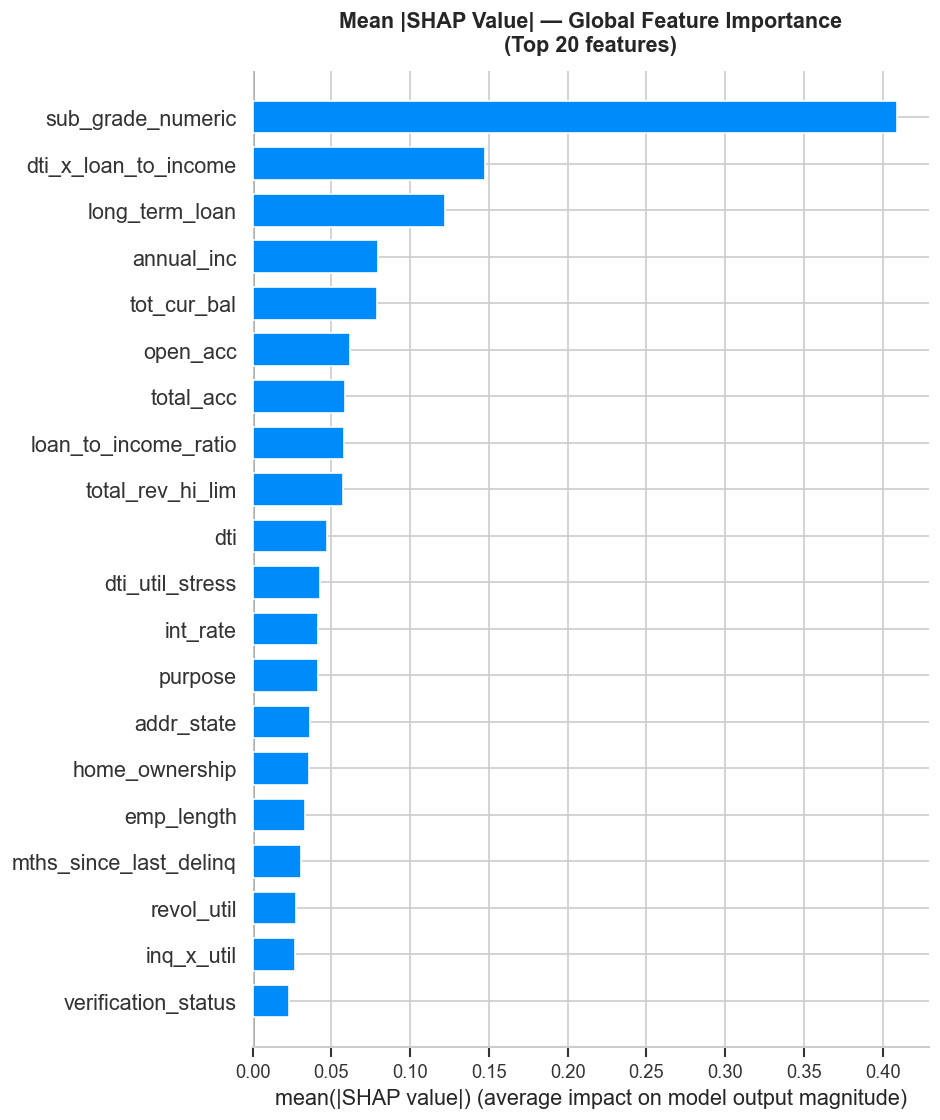

TOP 5 RISK DRIVERS — SHAP IMPORTANCE WITH BUSINESS INTERPRETATION

  1. sub_grade_numeric
     Mean |SHAP| = 0.4089
     Lending Club's internal risk grade (A1=1 through G5=35). This is the platform's own credit assessment — the single strongest signal in the model by a large margin.

  2. dti_x_loan_to_income
     Mean |SHAP| = 0.1472
     Engineered: DTI multiplied by loan-to-income ratio. Captures compound financial stress — borrowers who are simultaneously over-leveraged overall AND taking a large loan vs. their income.

  3. long_term_loan
     Mean |SHAP| = 0.1220
     Binary: 1 if 60-month term, 0 if 36-month. 60-month loans give more time for adverse life events to disrupt repayment. Default rate: ~35% (60-month) vs. ~19% (36-month) in this data.

  4. annual_inc
     Mean |SHAP| = 0.0792
     Borrower's self-reported annual income (capped at $240k). Higher income = larger buffer against repayment shocks. Effect is non-linear: income below ~$40k is disproportionately risky.

  

In [3]:
# ── Display SHAP feature importance from NB06 ────────────────────────────────
# The SHAP analysis was performed on a stratified 15,000-row sample of the test
# set in NB06. We display the saved bar chart and summarise the top 5 drivers
# with business-language interpretations below.

from IPython.display import Image, display
display(Image('outputs/shap_plots/shap_bar.png', width=720))

# ── Top risk drivers with business interpretation ─────────────────────────────
import numpy as np

shap_values   = np.load('outputs/shap_plots/shap_values.npy')
feature_names = __import__('pandas').read_csv(
    'outputs/shap_plots/feature_names.csv', header=None)[0].tolist()

mean_abs_shap = __import__('pandas').Series(
    np.abs(shap_values).mean(axis=0), index=feature_names
).sort_values(ascending=False)

interpretations = {
    'sub_grade_numeric':    "Lending Club's internal risk grade (A1=1 through G5=35). "
                            "This is the platform's own credit assessment — the single "
                            "strongest signal in the model by a large margin.",
    'dti_x_loan_to_income': "Engineered: DTI multiplied by loan-to-income ratio. Captures "
                            "compound financial stress — borrowers who are simultaneously "
                            "over-leveraged overall AND taking a large loan vs. their income.",
    'long_term_loan':       "Binary: 1 if 60-month term, 0 if 36-month. 60-month loans "
                            "give more time for adverse life events to disrupt repayment. "
                            "Default rate: ~35% (60-month) vs. ~19% (36-month) in this data.",
    'annual_inc':           "Borrower's self-reported annual income (capped at $240k). "
                            "Higher income = larger buffer against repayment shocks. "
                            "Effect is non-linear: income below ~$40k is disproportionately risky.",
    'tot_cur_bal':          "Total current outstanding balance across ALL borrower accounts "
                            "(credit cards, mortgages, auto loans). Very high total balances "
                            "among otherwise creditworthy borrowers often signal over-extension.",
}

print("TOP 5 RISK DRIVERS — SHAP IMPORTANCE WITH BUSINESS INTERPRETATION")
print("=" * 75)
for rank, (feat, shap_val) in enumerate(mean_abs_shap.head(5).items(), 1):
    print(f"\n  {rank}. {feat}")
    print(f"     Mean |SHAP| = {shap_val:.4f}")
    print(f"     {interpretations.get(feat, '')}")
print("=" * 75)
print(f"\nNote: SHAP values are on the log-odds scale. A mean |SHAP| of {mean_abs_shap.iloc[0]:.2f}")
print(f"for sub_grade_numeric means it moves predictions by ±{mean_abs_shap.iloc[0]:.2f} log-odds")
print(f"on average — roughly 4-8× the impact of the #2 feature.")


### What the Risk Drivers Tell an Underwriter

**The model is anchored in Lending Club's own credit assessment.** `sub_grade_numeric` (their internal grade) is 4–8× more important than any other single feature. This validates that Lending Club's grading is genuinely predictive — the model isn't finding hidden signals that contradict the platform's view, it's confirming and extending it.

**The next three features are all about financial stretch.** The interaction term (`dti_x_loan_to_income`), the loan term flag, and income all capture whether the borrower is financially capable of sustaining payments through the full term. A borrower who looks fine on any one of these factors but is stressed on all three simultaneously represents a risk that the model compounds — this is one of the key advantages of tree-based models over scorecards: they naturally capture multi-factor risk profiles.

**Actionable underwriting guidance:** The borrowers most likely to default share a pattern across multiple dimensions simultaneously:
1. Assigned to grade C or lower by Lending Club
2. Loan-to-income ratio above 0.40 (loan exceeds 40% of annual income)
3. DTI above 25% (one quarter of income already committed to debt service)
4. 60-month term selected
5. Revolving credit utilization above 60%

No single factor is disqualifying in isolation — it is the *combination* that signals compounding risk. The model's tree structure naturally captures these "and" conditions that are difficult to encode in a traditional scorecard.

**Independent validation from WoE/IV:** The Information Value analysis in NB07 confirmed these rankings using a completely model-free method. `sub_grade_numeric` (IV = 0.41, **Strong**), `dti_x_loan_to_income` (IV = 0.19, **Medium**), and the loan term (IV = 0.15, **Medium**) topped both rankings. When two independent analytical methods agree, the feature importance is a property of the data — not an artifact of the specific model chosen.


---
## 3. Traditional Scorecard Perspective

NB07 explored the traditional credit scoring approach as a complement to the ML model. The findings are worth summarising here because they inform deployment strategy.

**The WoE scorecard using 10 features achieved ROC-AUC = 0.7045** — representing **98.2% of XGBoost's performance** (0.7175) while using 43 fewer features and requiring no machine learning infrastructure to operate. The scorecard lives entirely in a coefficient table: a loan officer looks up which bin each applicant falls into, reads off the WoE for each characteristic, multiplies by the coefficient, and sums to a final score.

**Where the gap shows up is not in recall but in precision.** At the same 0.40 threshold, both models catch 82.4% of defaults (essentially identical recall). The XGBoost model generates ~880 fewer false alarms on the 54,178-loan test set — a precision advantage that comes from its ability to use all 53 features to distinguish borderline cases the scorecard cannot differentiate.

**The two approaches are complementary, not competing:**

| Use case | Recommended approach |
|----------|---------------------|
| Primary decisioning (automated) | XGBoost — higher precision reduces operational false alarm volume |
| Regulatory reporting / model documentation | WoE scorecard — every factor is auditable by examiners |
| Loan officer override decisions | WoE scorecard — points table is self-explanatory without data science support |
| Fair lending analysis | WoE scorecard — protected class contribution to decisions is immediately visible |
| Model risk management validation | Both — agreement between methods strengthens validation argument |

Many mature credit risk teams maintain both: the ML model governs automated decisions, and the scorecard is maintained for regulatory use and as a challenger model. This project demonstrates the capability to build and evaluate both.


---
## 4. Deployment Recommendations

### Recommended operational workflow

The following staging approach balances risk management with customer experience:

```
Application received
        ↓
Model scores loan (XGBoost probability 0.0 – 1.0)
        ↓
┌──────────────────────────────────────────────────────┐
│  Score < 0.25  →  Auto-approve  (low risk)           │
│  Score 0.25–0.40  →  Human review  (borderline)      │
│  Score > 0.40  →  Flag / decline  (high risk)        │
└──────────────────────────────────────────────────────┘
        ↓
For human review tier: loan officer applies scorecard table
to confirm or override the model flag
```

The "human review" band (0.25–0.40) is the borderline zone where the model is most uncertain. Routing these to human review costs more operationally but catches cases the model is genuinely unsure about — and the WoE scorecard gives loan officers a tool to make those reviews without relying on the black-box score.

### Model monitoring

After deployment, the model will degrade as the economic environment shifts. The following monitoring cadence is recommended:

| Monitoring item | Frequency | Action trigger |
|-----------------|-----------|----------------|
| **Population Stability Index (PSI)** on top 10 features | Monthly | PSI > 0.2 → flag for retraining |
| **Actual default rate vs. predicted** | Monthly | Divergence > 3pp for 2 consecutive months → investigate |
| **ROC-AUC on new loans** (as outcomes resolve) | Quarterly | Drop > 0.03 → initiate retraining |
| **False alarm rate** | Monthly | Increase > 10% → threshold review |
| **Feature drift** on `sub_grade_numeric` and `dti_x_loan_to_income` | Monthly | Distribution shift > 15% → alert |

**PSI (Population Stability Index)** is a standard credit risk monitoring metric that measures how much the distribution of a feature has shifted between when the model was trained and now. PSI < 0.1 = stable; 0.1–0.2 = minor shift; > 0.2 = significant shift requiring investigation.

### Limitations and caveats

**1. Data vintage and economic regime.** This model was trained on Lending Club loans from a specific historical period. Consumer credit behavior changes with interest rate cycles, unemployment rates, and macroeconomic conditions. A model calibrated on pre-2020 data may not reflect post-2020 credit dynamics without recalibration.

**2. Historical selection bias.** Lending Club's historical loan population reflects their past underwriting criteria — loans they chose to originate. The model has never seen the population of applicants *declined* by Lending Club (counterfactual outcomes are unobservable). If deployment changes the applicant mix significantly, model performance may shift.

**3. `sub_grade_numeric` dominance.** The model relies heavily on Lending Club's own risk assessment. This is appropriate when deploying within Lending Club's origination system. If adapting for use at an institution with a different grading methodology, this feature would need to be replaced with a comparable internal score.

**4. Annual income is self-reported.** The `annual_inc` feature has not been verified against tax records or pay stubs in this dataset. Income misrepresentation in applications is a known fraud vector that this model cannot detect.

**5. Threshold recalibration on live data.** The 0.40 threshold was optimized on the historical test set. On live data with different default rates or loan compositions, the cost-optimal threshold may shift. A champion-challenger framework where the threshold is periodically re-evaluated against realized costs is recommended.

### Suggested next steps

1. **A/B test the model** against the current decisioning process on a 10% traffic split, measuring actual default rates in approved loans and false-decline rates (measured by re-applications at competitors)
2. **Implement a champion-challenger framework** where the current scorecard remains the "champion" and this XGBoost model is the "challenger" — gradually increasing challenger traffic as performance is validated on live data
3. **ECOA adverse action notice review** — for any loan declined based on model output, ensure the top 3 SHAP features can be translated into plain-language reason codes that satisfy Equal Credit Opportunity Act requirements ("Your application was affected by: high debt-to-income ratio, large loan relative to income, and 60-month term selected")
4. **Explore model refresh cadence** — retrain annually on the trailing 24–36 months of data to capture evolving credit behaviour while maintaining sufficient sample for stable minority-class estimation


In [4]:
# ── Technical Specifications — Reference for Model Validators ─────────────────
print("=" * 70)
print("TECHNICAL APPENDIX — MODEL SPECIFICATIONS")
print("=" * 70)
print(f"  Model type:           XGBoost (XGBClassifier)")
print(f"  Imbalance strategy:   Class weighting (scale_pos_weight={meta['scale_pos_weight']})")
print(f"  Decision threshold:   {meta['threshold']}")
print(f"  Cost ratio used:      5:1 (missed default : false decline)")
print(f"  Training set size:    {meta['train_rows']:,} rows")
print(f"  Test set size:        {meta['test_rows']:,} rows (held out, used once)")
print(f"  Feature count:        {meta['n_features']} features")
print()
print("  Hyperparameters (from RandomizedSearchCV, 50 iter, 5-fold StratifiedKFold):")
for param, val in meta['best_params'].items():
    print(f"    {param:<20}  {val}")
print()
print("  Test Set Performance:")
for metric, val in meta['performance'].items():
    if metric in ('roc_auc','pr_auc','precision','recall','f1'):
        print(f"    {metric:<20}  {val:.4f}")
    elif metric in ('tp','fp','fn','tn','cost_5to1'):
        print(f"    {metric:<20}  {val:,}")
print()
print("  Feature list (53 features):")
for i, feat in enumerate(meta['features'], 1):
    print(f"    {i:2d}. {feat}")
print("=" * 70)
print()
print("  Key output files:")
outputs = [
    ("outputs/best_model.joblib",            "Trained XGBoost pipeline (preprocessor + classifier)"),
    ("outputs/model_metadata.json",           "Hyperparameters, threshold, performance metrics"),
    ("outputs/shap_plots/shap_beeswarm.png",  "SHAP beeswarm — global feature impact"),
    ("outputs/shap_plots/shap_bar.png",       "SHAP bar — mean |SHAP| per feature"),
    ("outputs/shap_plots/shap_dependence.png","SHAP dependence plots — top 3 features"),
    ("outputs/shap_plots/shap_waterfall.png", "SHAP waterfall — 3 individual predictions"),
    ("outputs/woe_plots/woe_bar_charts.png",  "WoE bar charts — top 10 features"),
    ("outputs/woe_plots/iv_ranking.png",      "IV ranking chart"),
    ("outputs/woe_plots/model_comparison.png","XGBoost vs WoE LR comparison curves"),
]
for path, desc in outputs:
    print(f"  {path:<45}  {desc}")


TECHNICAL APPENDIX — MODEL SPECIFICATIONS
  Model type:           XGBoost (XGBClassifier)
  Imbalance strategy:   Class weighting (scale_pos_weight=3.428)
  Decision threshold:   0.4
  Cost ratio used:      5:1 (missed default : false decline)
  Training set size:    216,709 rows
  Test set size:        54,178 rows (held out, used once)
  Feature count:        53 features

  Hyperparameters (from RandomizedSearchCV, 50 iter, 5-fold StratifiedKFold):
    subsample             0.8
    n_estimators          300
    min_child_weight      7
    max_depth             3
    learning_rate         0.05
    gamma                 0.1
    colsample_bytree      1.0

  Test Set Performance:
    roc_auc               0.7175
    pr_auc                0.4176
    precision             0.3088
    recall                0.8235
    f1                    0.4492
    cost_5to1             33,346
    tp                    10,076
    fp                    22,551
    fn                    2,159
    tn            

---
## 🛑 Breakpoint — Final Review

**NB08 (Business Summary) is complete.**

This notebook is the portfolio-facing deliverable — the document a hiring manager or risk committee should be able to read without opening any other notebook. Before I finalise and create the README, please review NB08 and let me know:

1. **Is the tone right?** The target audience is a hiring manager or analyst with business context but not necessarily deep ML background. Does the narrative land at the right level?

2. **Are there any numbers or findings you want reframed or expanded?** The executive summary, business impact translation ($7.3M net benefit per 10k loans), and the deployment recommendations are the highest-visibility sections.

3. **Anything from the project you feel should be highlighted more prominently?** For example: the WoE/IV scorecard story, the feature engineering contribution, or the threshold trade-off decision.

4. **Once you're happy with NB08: ready for me to create the README?** The README will be the repository entry point — covering the problem, approach, key results, notebook guide, tech stack, and reproduction instructions.
